In [2]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import time
pd.set_option('expand_frame_repr',False)
pd.set_option('display.max_rows', 5000)

In [3]:
def get_stock(symbol, start, end):
    return yf.Ticker(symbol).history(start=start, end=end)

end = datetime.datetime.now()
begin = datetime.date(end.year - 2, end.month, end.day)

stock = get_stock('udow',
                  begin,
                  end)

In [4]:
stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-20,17.793795,18.176832,14.555394,14.734476,17042800,0.00,0.0
2020-03-23,14.436007,14.674783,12.595441,13.446081,30004800,0.00,0.0
2020-03-24,15.903484,17.972878,15.624912,17.838566,24172600,0.00,0.0
2020-03-25,18.935401,21.373371,17.504528,19.154768,33530600,0.04,0.0
2020-03-26,19.932528,22.983730,19.822844,22.704536,30086000,0.00,0.0


In [5]:
# MA_lower = usually use MA10,  MA_upper = usually use MA60
def MA(MA_lower,MA_upper):
    stock['ClosePlusOne'] = stock['Close'].shift(-1)
    stock['change'] = stock['Close'].shift(-1)/stock['Close'] - 1

    stock['MA10'] = stock['Close'].rolling(MA_lower,min_periods=1).mean()
    stock['MA60'] = stock['Close'].rolling(MA_upper,min_periods=1).mean()

    # buy signal
    condition1 = stock['MA10'] > stock['MA60']
    condition2 = stock['MA10'].shift(1) <= stock['MA60'].shift(1)
    stock.loc[condition1 & condition2,'signal'] = 1

    # sell signal
    condition1 = stock['MA10'] < stock['MA60']
    condition2 = stock['MA10'].shift(1) >= stock['MA60'].shift(1)
    stock.loc[condition1 & condition2,'signal'] = 0

    new = stock.query('signal == 1 or signal == 0')

    # the new dataframe mus start with 1 and end with 0, one buy one sell
    if new['signal'].tail(1).values[0] == 1:
        new.drop(new.tail(1).index,
                 inplace = True)
    if new['signal'].head(1).values[0] == 0:
        new.drop(new.head(1).index,
                 inplace = True)

    signal_1 = new.query('signal == 1').reset_index()
    signal_2 = new.query('signal == 0').reset_index()

    final_df = signal_2.copy()
    final_df['change_strategy'] = signal_2['Close']/signal_1['Close'] - 1

    strategy_return = (final_df['change_strategy'] + 1).cumprod()
    holding_return = (stock['change'] + 1).cumprod()
    print('strategy_return = {}'.format(strategy_return.values[-1]))
    print('holding_return = {}'.format(holding_return.values[-2]))

    plt.subplot(2,1,1)
    plt.plot(final_df['Date'],strategy_return,
             label = 'Strategy Return',
             color = 'r')
    plt.plot(holding_return,
             label = 'holding return',
             color = 'b')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(stock['Close'],label='DJ')
    plt.plot(stock['MA10'],label = 'MA10',alpha = 0.6)
    plt.plot(stock['MA60'],label = 'MA60',alpha = 0.6)
    plt.scatter(signal_1['Date'],stock.loc[signal_1['Date']]['Close'],
                label = 'open',
                color = 'r',
                marker='^')
    plt.scatter(signal_2['Date'],stock.loc[signal_2['Date']]['Close'],
                label = 'close',
                color = 'black',
                marker= 'v')
    plt.legend()

strategy_return = 1.9825786682704318
holding_return = 4.970655041890014


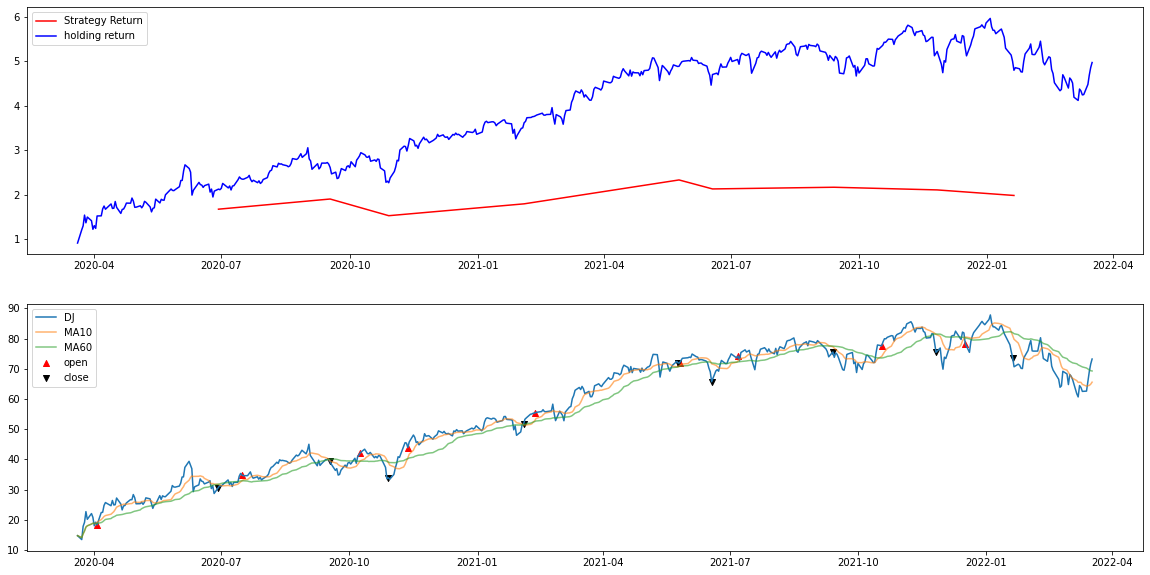

In [6]:
plt.figure(figsize=(20,10))
MA(10,30)

In [7]:
# EWMA_lower = usually use MA10,  EWMA_upper = usually use MA60
def EWMA(EWMA_lower,EWMA_upper):
    stock['ClosePlusOne'] = stock['Close'].shift(-1)
    stock['change'] = stock['Close'].shift(-1)/stock['Close'] - 1

    stock['EWMA10'] = stock['Close'].ewm(span=EWMA_lower).mean()
    stock['EWMA60'] = stock['Close'].ewm(span=EWMA_upper).mean()
    # buy signal
    condition1 = stock['EWMA10'] > stock['EWMA60']
    condition2 = stock['EWMA10'].shift(1) <= stock['EWMA60'].shift(1)
    stock.loc[condition1 & condition2,'signal'] = 1

    # sell signal
    condition1 = stock['EWMA10'] < stock['EWMA60']
    condition2 = stock['EWMA10'].shift(1) >= stock['EWMA60'].shift(1)
    stock.loc[condition1 & condition2,'signal'] = 0

    new = stock.query('signal == 1 or signal == 0')

    # the new dataframe mus start with 1 and end with 0, one buy one sell
    if new['signal'].tail(1).values[0] == 1:
        new.drop(new.tail(1).index,
                 inplace = True)
    if new['signal'].head(1).values[0] == 0:
        new.drop(new.head(1).index,
                 inplace = True)

    signal_1 = new.query('signal == 1').reset_index()
    signal_2 = new.query('signal == 0').reset_index()

    final_df = signal_2.copy()
    final_df['change_strategy'] = signal_2['Close']/signal_1['Close'] - 1

    strategy_return = (final_df['change_strategy'] + 1).cumprod()
    holding_return = (stock['change'] + 1).cumprod()
    print('strategy_return = {}'.format(strategy_return.values[-1]))
    print('holding_return = {}'.format(holding_return.values[-2]))

    plt.subplot(2,1,1)
    plt.plot(final_df['Date'],strategy_return,
             label = 'Strategy Return',
             color = 'r')
    plt.plot(holding_return,
             label = 'holding return',
             color = 'b')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(stock['Close'],label='DJ')
    plt.plot(stock['EWMA10'],label = 'EWMA10',alpha = 0.6)
    plt.plot(stock['EWMA60'],label = 'EWMA60',alpha = 0.6)
    plt.scatter(signal_1['Date'],stock.loc[signal_1['Date']]['Close'],
                label = 'open',
                color = 'r',
                marker='^')
    plt.scatter(signal_2['Date'],stock.loc[signal_2['Date']]['Close'],
                label = 'close',
                color = 'black',
                marker= 'v')
    plt.legend()

c:\users\86130\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


strategy_return = 5.476573007539484
holding_return = 4.970655041890014


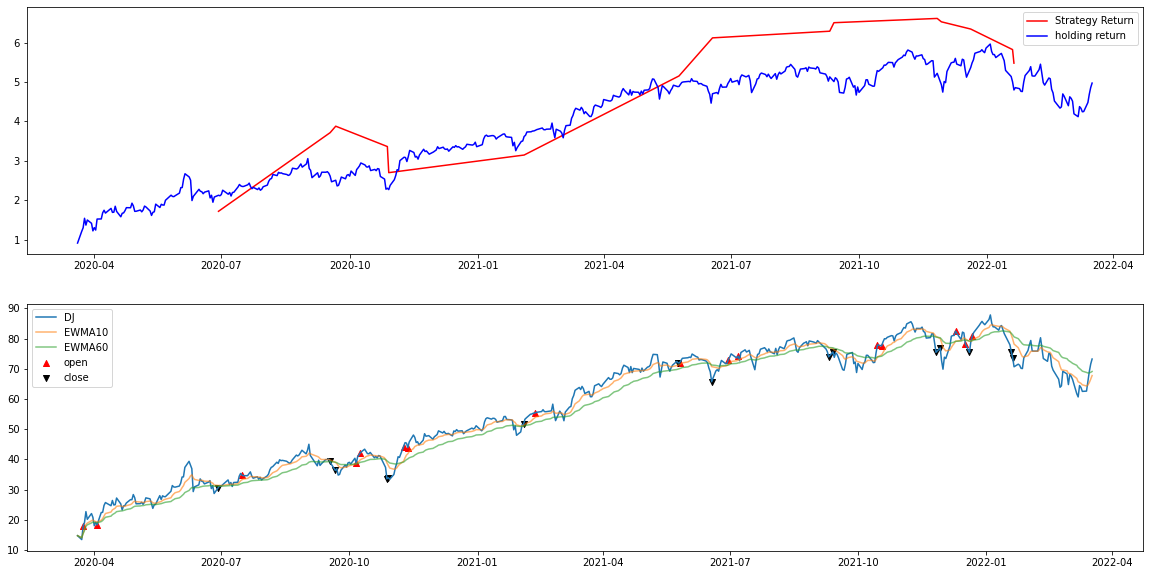

In [8]:
plt.figure(figsize=(20,10))
EWMA(10,30)